In [ ]:
#default_exp fully_connected_network_02

# Fully Connected Network
> Implementing backward and forward passes to train a simple fully connected network

In [ ]:
#export
from ModernArchitecturesFromScratch.basic_operations_01 import *
from nbdev.showdoc import *

# Data Loading

Near zero: 0.00012300178059376776


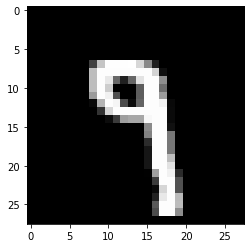

In [ ]:
#hide
xt,yt,xv,yv = get_mnist()

n_out = (yt.max()+1).item()
n_in = (xt[0].shape)[0]
test_near_zero(xt.mean())
show_im(xt)

# Initialization

In [ ]:
#export

#Kaiming initialization with fan_in
def get_weight(in_d, out_d, relu_after):
    "Returns weight matrix of size `in_d` x `out_d` initialized using Kaiming initialization"
    if relu_after: return torch.randn(in_d, out_d) * math.sqrt(2. / in_d)
    else: return torch.randn(in_d, out_d) / math.sqrt(in_d)

Please see: https://arxiv.org/abs/1502.01852 for more details and explanation on Kaiming initialisation.

In [ ]:
get_weight(4,5, True)

tensor([[ 0.3439, -0.8647, -0.3632, -0.4948,  0.1206],
        [ 1.1526,  0.0320, -0.1779,  0.0031, -0.5851],
        [-0.7234,  0.7781, -0.2957, -0.2883, -0.0954],
        [ 0.8227, -0.4535, -0.2321,  0.4181,  0.5786]])

# Forward Pass

In [ ]:
#export   
#hide
def linear(x, w, b): 
    "Basic linear layer"
    return x @ w + b

In [ ]:
#export
#hide
def relu(x): 
    "ReLU activation function"
    return x.clamp_min(0.) - 0.

In [ ]:
#export
#hide
def lin_rel(x, w, b): 
    "Linear layer followed by ReLU activation on `x` with weight `w` and bias `b`"
    return relu(linear(x, w, b))

In [ ]:
#export
#hide
def softmax(x): 
    "Softmax activation function"
    return torch.exp(x) / torch.sum(torch.exp(x.unsqueeze(-1)), dim=1)

In [ ]:
#hide
n_in = 28**2
n_out = 10

w1 = get_weight(n_in, 50, True)
w2 = get_weight(50, n_out, False)
b1 = torch.zeros(50)
b2 = torch.zeros(n_out)

In [ ]:
#hide
def forward_pass(xb):
    xb = lin_rel(xb, w1, b1)
    xb = linear(xb, w2, b2)
    return xb

In [ ]:
#hide
result = forward_pass(xt)

In [ ]:
#hide
get_stats(result)

Mean: -0.12942148745059967
Std: 1.041248083114624


# Loss

In [ ]:
#export
#hide
def mse_loss(xb, yb): 
    "Mean Square Error loss"
    return (xb.squeeze(-1) - yb).pow(2).mean()

In [ ]:
eps = 1e-9
#hide
def cross_entropy(xb, targ): 
    "Cross Entropy Loss"
    return -( (xb + eps).log()[range(targ.shape[0]), targ.long()].mean() )

# Backwards Pass

In [ ]:
def mse_grad(inp, targ):
    "Grad for mean squared error"
    inp.g = 2. * (inp.squeeze(-1) - targ).unsqueeze(-1) / inp.shape[0]

In [ ]:
def rel_grad(inp, out):
    "Grad for ReLU layer"
    inp.g = out.g * (inp > 0).float()

In [ ]:
def lin_grad(inp, out, w, b):
    "Grad for linear layer"
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [ ]:
def softmax_cross_grad(inp, targ):
    "Grad for softmax and cross entropy loss"
    targ = torch.nn.functional.one_hot(targ.to(torch.int64), 10)
    inp_s = softmax(inp)
    inp.g = ( inp_s - targ ) / targ.shape[0]

Putting it all together...

In [ ]:
def full_pass(xb, targ):
    l1 = linear(xb, w1, b1)
    l1_r = relu(l1)
    l2 = linear(l1_r, w2, b2)
    
    soft = softmax(l2)
    
    loss = cross_entropy(soft, targ)
    
    softmax_cross_grad(l2, targ)
    lin_grad(l1_r, l2, w2, b2)
    rel_grad(l1, l1_r)
    lin_grad(xb, l1, w1, b1)
    
    return loss

In [ ]:
loss = full_pass(xt, yt)
loss

tensor(2.9962)

In [ ]:
#hide
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = xt.g.clone()

In [ ]:
#hide
xt2 = xt.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [ ]:
#hide
def auto_full_pass(xb, targ):
    l1 = linear(xb, w12, b12)
    l1_r = relu(l1)
    l2 = linear(l1_r, w22, b22)
    soft = softmax(l2)
    
    loss = cross_entropy(soft, targ)
    
    return loss

In [ ]:
#hide
loss = auto_full_pass(xt2, yt)

In [ ]:
#hide
loss.backward()

In [ ]:
#hide
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

good
good
good
good
good


# Refactoring

In [ ]:
#export
class Module():
    "Base class for every layer operation in a sequential network"
    def __call__(self, *args):
        "Executes forward pass of module and stores result in `self.out` for backwards pass"
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): 
        "Executes desired operation of module"
        raise Exception("Not Implemented")
        
    def backward(self): 
        "Calls backwards method to find gradient with stored output of layer"
        self.bwd(self.out, *self.args)

In [ ]:
show_doc(Module.__call__)
show_doc(Module.forward)
show_doc(Module.backward)

<h4 id="Module.__call__" class="doc_header"><code>Module.__call__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Module.__call__</code>(**\*`args`**)

Executes forward pass of module and stores result in `self.out` for backwards pass

<h4 id="Module.forward" class="doc_header"><code>Module.forward</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>Module.forward</code>()

Executes desired operation of module

<h4 id="Module.backward" class="doc_header"><code>Module.backward</code><a href="__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>Module.backward</code>()

Calls backwards method to find gradient with stored output of layer

In [ ]:
#export
class Linear(Module):
    def __init__(self, in_d, out_d, final): 
        "Initialize weight using 'get_weight' and bias to 0 for linear operation"
        self.w, self.b = get_weight(in_d, out_d, final), torch.zeros(out_d)

    def forward(self, xb): 
        "Perform forward linear pass"
        return xb @ self.w + self.b

    def bwd(self, out, inp):
        "Gradient with respect to the forward linear layer"
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [ ]:
show_doc(Linear.__init__)
show_doc(Linear.forward)
show_doc(Linear.bwd)

<h4 id="Linear.__init__" class="doc_header"><code>Linear.__init__</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>Linear.__init__</code>(**`in_d`**, **`out_d`**, **`final`**)

Initialize weight using 'get_weight' and bias to 0 for linear operation

<h4 id="Linear.forward" class="doc_header"><code>Linear.forward</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>Linear.forward</code>(**`xb`**)

Perform forward linear pass

<h4 id="Linear.bwd" class="doc_header"><code>Linear.bwd</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>Linear.bwd</code>(**`out`**, **`inp`**)

Gradient with respect to the forward linear layer

In [ ]:
#export
class ReLU(Module):
    def forward(self, x): 
        "Set all activations to have a minimum of zero, subtract 0.5 to maintain mean of 0"
        return x.clamp_min_(0.)-0.5
    
    def bwd(self, out, inp): 
        "Backward with respect to the ReLU layer"
        inp.g = (inp>0).float() * out.g

In [ ]:
show_doc(ReLU.forward)
show_doc(ReLU.bwd)

<h4 id="ReLU.forward" class="doc_header"><code>ReLU.forward</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>ReLU.forward</code>(**`x`**)

Set all activations to have a minimum of zero, subtract 0.5 to maintain mean of 0

<h4 id="ReLU.bwd" class="doc_header"><code>ReLU.bwd</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>ReLU.bwd</code>(**`out`**, **`inp`**)

Backward with respect to the ReLU layer

In [ ]:
#export
eps = 1e-9
class CrossSoft(Module):
    def forward(self, inp, targ):
        "Calls `soft_forward` and `cross_loss` on inp compared with `targ`"
        softed = self.soft_forward(inp)
        return self.cross_loss(softed, targ)
    
    def soft_forward(self, x): 
        "Implements softmax activation function on `x`"
        return torch.exp(x) / torch.sum(torch.exp(x.unsqueeze(-1)), dim=1)
        
    def cross_loss(self, xb, targ): 
        "Cross entropy loss of `xb` compared to `targ`"
        return -( (xb + eps).log()[range(targ.shape[0]), targ.long()].mean() )
    
    def bwd(self, loss, inp, targ):
        "Gradient with respect to both softmax and cross entropy loss"
        targ = torch.nn.functional.one_hot(targ.to(torch.int64), 10)
        inp_s = softmax(inp)
        inp.g = ( inp_s - targ ) / targ.shape[0]

In [ ]:
show_doc(CrossSoft.forward)
show_doc(CrossSoft.soft_forward)
show_doc(CrossSoft.cross_loss)
show_doc(CrossSoft.bwd)

<h4 id="CrossSoft.forward" class="doc_header"><code>CrossSoft.forward</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>CrossSoft.forward</code>(**`inp`**, **`targ`**)

Calls `soft_forward` and `cross_loss` on inp compared with `targ`

<h4 id="CrossSoft.soft_forward" class="doc_header"><code>CrossSoft.soft_forward</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>CrossSoft.soft_forward</code>(**`x`**)

Implements softmax activation function on `x`

<h4 id="CrossSoft.cross_loss" class="doc_header"><code>CrossSoft.cross_loss</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>CrossSoft.cross_loss</code>(**`xb`**, **`targ`**)

Cross entropy loss of `xb` compared to `targ`

<h4 id="CrossSoft.bwd" class="doc_header"><code>CrossSoft.bwd</code><a href="__main__.py#L17" class="source_link" style="float:right">[source]</a></h4>

> <code>CrossSoft.bwd</code>(**`loss`**, **`inp`**, **`targ`**)

Gradient with respect to both softmax and cross entropy loss

In [ ]:
#export
#hide
class Model():
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

    def backward(self):
        for l in reversed(self.layers): l.backward()

### Testing Output and Gradients

In [ ]:
layers = [Linear(784,50,True), ReLU(), Linear(50,10, False)]
loss_func = CrossSoft()
model = Model(layers)
loss = loss_func(model(xt),yt)

In [ ]:
loss_func.backward()
model.backward()

In [ ]:
w1g = model.layers[0].w.g.clone()
w2g = model.layers[2].w.g.clone()
b1g = model.layers[0].b.g.clone()
b2g = model.layers[2].b.g.clone()
ig  = xt.g.clone()

In [ ]:
xt = xt.clone().requires_grad_(True)
model.layers[0].w = model.layers[0].w.clone().requires_grad_(True)
model.layers[0].b = model.layers[0].b.clone().requires_grad_(True)
model.layers[2].w = model.layers[2].w.clone().requires_grad_(True)
model.layers[2].b = model.layers[2].b.clone().requires_grad_(True)

In [ ]:
%time loss = loss_func(model(xt), yt)

CPU times: user 227 ms, sys: 24.3 ms, total: 251 ms
Wall time: 62.9 ms


In [ ]:
%time loss.backward()

CPU times: user 796 ms, sys: 48.3 ms, total: 845 ms
Wall time: 124 ms


In [ ]:
test_near(w2g, model.layers[2].w.grad)
test_near(b2g, model.layers[2].b.grad)
test_near(w1g, model.layers[0].w.grad)
test_near(b1g, model.layers[0].b.grad)
test_near(ig, xt.grad)

good
good
good
good
good
